Tutorial Version 1.0

Author: Jack Henderson

Date: 01/18/2020

# Requirements
-) Lambda Files

# Analyzing lambda files and log files from AMBER CpHMD Asynchronous Replica Exchange

Here we will process the lambda file output from CpHMD simulations using a small protein, BBL, as an example case. We will start by showing how to use the CpHMD Analysis module and go through computing and plotting the unprotonated fractions to obtain the pKas and titration curves as well as hot to check the convergence of the pKas by plotting the running average of the unprotonated fraction over time. Finally we will calculate the replica exchange, exchange frequences between pH replicas and how to plot the replica walks.

# Load Libraries

In [1]:
import cphmdanalysis as cphmd
from cphmdanalysis import compute_pkas as pka
from cphmdanalysis import HH_fitting as pka_fit
from cphmdanalysis import plotting_lambda_data as plotting
import glob as g

# Paths, pHs, and Stages

To start we need to make a list of the pH environements used for the replicas-exchange CpHMD simulation. In this case we used a pH range from 2.5 to 8.0 and incremented the pH environment by 0.5 pH units. A pH unit spacing of 0.5 pH units works very well in most cases but occasionally you will have to decrease the spacing to improve the exchange rate betwen replicas. The greater the spacing is the lower the exchange frequency will be. More will be discussed on this when we look at the replica walks and exchange frequency. 

The sstage and lstage varible are the stages for which the simulation has been restart. In this case the simulation has only been restarted one with an sstage of 1 being the start of the simulation and a lstage of 2 being the end of the simulation.

In [2]:
phs    = [2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
sstage = 1
lstage = 2
stages = [x for x in range(sstage, lstage+1)]

# Handling and Loading Lambda Files

## Seed Files

One of the first steps to analyzing lambda files is to create a list of the lambda files you want to process. The 'files' list in the following cell is just that. For easy of use you will want the files to be ordered from lowest to highest pH in the list. In this case the rep0.lambda file is the lowest pH file (pH 2.5) and the rep11.lambda is the highest (pH 8.0).

In [3]:
files = []
for rep, ph in enumerate(phs):
    files.append(g.glob('amber_example_data/sample_{}/rep{}.lambda'.format(sstage, rep)))

Now you will use the cphmd function 'lambda_data' to load in the lambda values, see the list comprehension below. The parser is able to read the files and the 'data' list will contain an object for each pH.  

In [4]:
ph_objects = [cphmd.lambda_data(x[0]) for x in files]

In [5]:
print('Number of pH objects in the data list: {}'.format(len(ph_objects)))
print('Number of pH replicas used: {}'.format(len(files)))

Number of pH objects in the data list: 12
Number of pH replicas used: 12


## Add Lambda Files

In some case you will have subsequent lambda files. For instance when you run a CpHMD simulation for 10ns then extended it to 20ns you will have a lambda file for each pH for the first and second runs. The 'add_l_file' function from the cphmdanalysis library allows you to extend the previously generated 'ph_objects' with the subsequent lambda file data. 

In [6]:
for rep, ph in enumerate(phs):
    for stage in stages[1:]:
        file = g.glob('amber_example_data/sample_{}/rep{}.lambda'.format(stage, rep))
        ph_objects[rep].add_l_file(file_path=file[0])
        print("{} Added".format(file[0]))

amber_example_data/sample_2/rep0.lambda Added
amber_example_data/sample_2/rep1.lambda Added
amber_example_data/sample_2/rep2.lambda Added
amber_example_data/sample_2/rep3.lambda Added
amber_example_data/sample_2/rep4.lambda Added
amber_example_data/sample_2/rep5.lambda Added
amber_example_data/sample_2/rep6.lambda Added
amber_example_data/sample_2/rep7.lambda Added
amber_example_data/sample_2/rep8.lambda Added
amber_example_data/sample_2/rep9.lambda Added
amber_example_data/sample_2/rep10.lambda Added
amber_example_data/sample_2/rep11.lambda Added


## Check Data

Now is a good time to make sure that everything that you have loaded matches your expectations. Like early make sure the length of the 'ph_objects' is correct. Next the 'n_itir' attribute will tell you the number of titratable sites. Finally you will want to check how many lambda values are stored for one titratable site. 

In [7]:
print('Number of pHs: {}'.format(len(ph_objects)))
print('Number of titra site: {}'.format(ph_objects[0].n_ititr))
print('Number of lambda vals: {}'.format(len(ph_objects[0].lambda_and_x_vals[0])))

Number of pHs: 12
Number of titra site: 19
Number of lambda vals: 5000


Using the 'info_table' attribute will allow you to print a nicely formatted pandas dataframe of all the standard lambda file information.

The first column gives you the list position of the lambda value or chi value of specific residues, which is the value you will use with the 'lambda_vals' attribute to select a specific column of information.


The second column gives you the ID of the titratable site.

The third column give you the resid.

The fourth column tells you which type of residue it is (0($\lambda$)=Lys,Arg,Cys; 1($\lambda$),2(Tautomer)=His; 3($\lambda$),4(Tautomer)=Asp,Glu

In [8]:
import pandas as pd
pd.set_option('display.max_rows', None) # prevents truncation of the dataframe
ph_objects[0].info_table

,Ititr,Ires,Itauto
0,1,5,3
1,2,5,4
2,3,17,3
3,4,17,4
4,5,18,1
5,6,18,2
6,7,21,3
7,8,21,4
8,9,26,0
9,10,37,3


# Do Calculation

## Imporant Residues

When calculating the pKas sometimes you need to focus on specific residues the 'find_residues' functions helps find the positions of these residues in the list of all lambda files. However, in this case we are interested in finding all the residues. You can play with the following cell by removing some values from the 'important_resides' list to narrow the data you will view. 

In [9]:
important_resids = [5, 17, 18, 21, 26, 37, 38, 40, 41, 42, 45]
resids = ph_objects[0].find_residues(important_resids)
print(resids)  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Calculate the Unprotonated Fraction foreach Titratable Site

Now that all the data is loaded and we have deteremined the residues we are interested in we must compute the unprotonated fraction for each residue using the 'compute_all_s_values' function. Notice here that the 'output' option is set to True, this will print additional information for you to see about each residues at each pH. Most importantaly you will be able to the the unprotonated for the whole residue followed by the unprotonated fraction for each site and you will see the percent pure and mixed states. Mixed states are when the lambda value resides between 0.2 and 0.8, which is a fictious transition state.

In [10]:
for x in range(len(ph_objects)):
    print('--- pH {} ----------------------------'.format(phs[x]))
    ph_objects[x].compute_all_s_values(output=True)

--- pH 2.5 ----------------------------
ires | itaut | S(unprot) | Pure | Mixed
   5     3       0.16      0.89   0.11
   5     4       0.31
   5     4       0.25
  17     3       0.05      0.93   0.07
  17     4       0.09
  17     4       0.10
  18     1       0.00      0.95   0.05
  18     2       0.00
  18     2       0.00
  21     3       0.47      0.89   0.11
  21     4       0.68
  21     4       0.59
  26     0       0.00      1.00   0.00
  37     3       0.13      0.91   0.09
  37     4       0.22
  37     4       0.23
  38     3       0.49      0.88   0.12
  38     4       0.68
  38     4       0.62
  40     3       0.07      0.91   0.09
  40     4       0.14
  40     4       0.13
  41     0       0.00      1.00   0.00
  42     1       0.00      0.94   0.06
  42     2       0.00
  42     2       0.00
  45     0       0.00      1.00   0.00
--- pH 3.0 ----------------------------
ires | itaut | S(unprot) | Pure | Mixed
   5     3       0.35      0.88   0.12
   5     4       0.5

  26     0       0.00      1.00   0.00
  37     3       1.00      0.96   0.04
  37     4       1.00
  37     4       1.00
  38     3       1.01      0.95   0.05
  38     4       1.00
  38     4       1.00
  40     3       1.00      0.95   0.05
  40     4       1.00
  40     4       1.00
  41     0       0.00      1.00   0.00
  42     1       0.96      0.87   0.13
  42     2       0.87
  42     2       0.92
  45     0       0.00      1.00   0.00
--- pH 8.0 ----------------------------
ires | itaut | S(unprot) | Pure | Mixed
   5     3       1.00      0.96   0.04
   5     4       1.00
   5     4       1.00
  17     3       1.01      0.95   0.05
  17     4       1.00
  17     4       1.00
  18     1       0.89      0.88   0.12
  18     2       0.85
  18     2       0.65
  21     3       1.00      0.96   0.04
  21     4       1.00
  21     4       1.00
  26     0       0.00      1.00   0.00
  37     3       1.00      0.96   0.04
  37     4       1.00
  37     4       1.00
  38     3       

# Calculate Running S Convergence

To see if the pKas have converged we must calculate the running average of the unprotonated fractions over time for each residue. This can be done with the 'compute_all_running_s' funtion, as shown below.

In [11]:
for x in range(len(phs)):
    ph_objects[x].compute_all_running_s()

For the most part the running average of the for each residue has converged for this test residue. The running unprotonated fraction at each pH appears to not be drifting for any residue, expect for maybe D38 pH 2.5. Some residues like the lysines have pKas to high for the simulated pH range and don't titrate during the simulations.

For additional information on the plot_running_s funtion type '?plotting.plot_running_s' into a new cell.

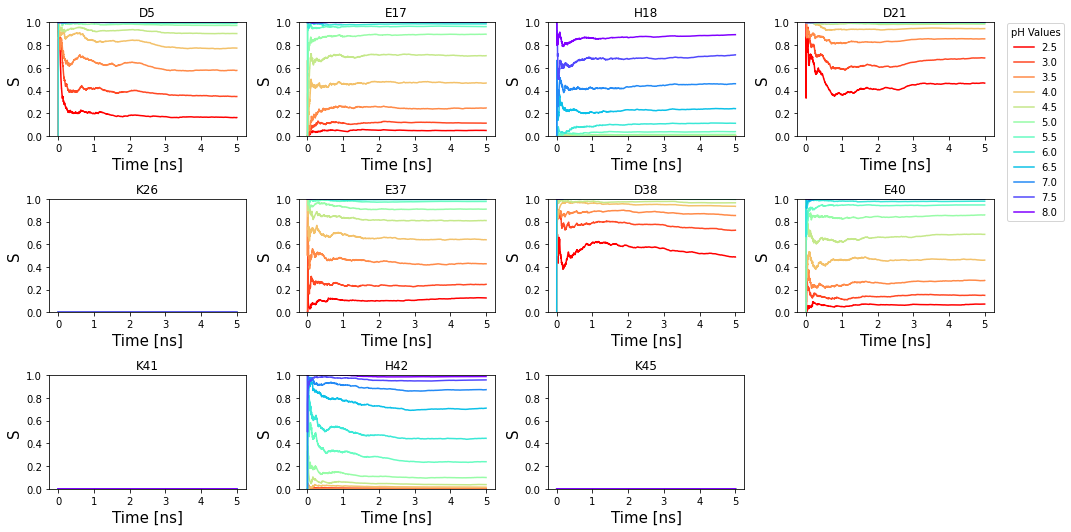

In [12]:
titles = ['D5', 'E17', 'H18', 'D21', 'K26', 'E37', 'D38', 'E40', 'K41', 'H42', 'K45']
plotting.plot_running_s(ph_objects, phs, resids, titles, xlabel='Time [ns]', steps_to_time_conversion=(1/1000), save_fig=True)

## Calculate pKas 

Finally we can calculate the pKas. To do this we use the 'compute_pkas,' which has been renamed to simply pka in this tutorial.

In [13]:
pkas = pka(phs, ph_objects)

As mentioned when looking at the running average of the unprotonated fractions some residues didn't titrate over the given pH range. 

In [14]:
for n, pka in enumerate(pkas):
    if pka[0] == 'NaN' or (pka[0] > max(phs) or pka[0] < min(phs)):
        print('Resid: {0:3} pKa: No Titration'.format(ph_objects[0].ires[n]))
    else:
        print('Resid: {0:3} pKa: {1:>3.1f} Hill: {2:>3.2f}'.format(ph_objects[0].ires[n], pka[0], pka[1]))

Resid:   5 pKa: 3.3 Hill: 0.84
Resid:  17 pKa: 4.0 Hill: 0.90
Resid:  18 pKa: 7.1 Hill: 0.91
Resid:  21 pKa: 2.6 Hill: 0.84
Resid:  26 pKa: No Titration
Resid:  37 pKa: 3.7 Hill: 0.75
Resid:  38 pKa: 2.5 Hill: 0.80
Resid:  40 pKa: 4.0 Hill: 0.77
Resid:  41 pKa: No Titration
Resid:  42 pKa: 6.1 Hill: 0.91
Resid:  45 pKa: No Titration


# Plot Titration Curves

Lastly we will plot the titration curves for each of the residues using the unprotonated fractions and fitting a line to those values using the generalized henderson-hasselbalch equation. Additionally, a red line will be used to denote where the 0.5 unprotonated fraction point is, which is the pKa.

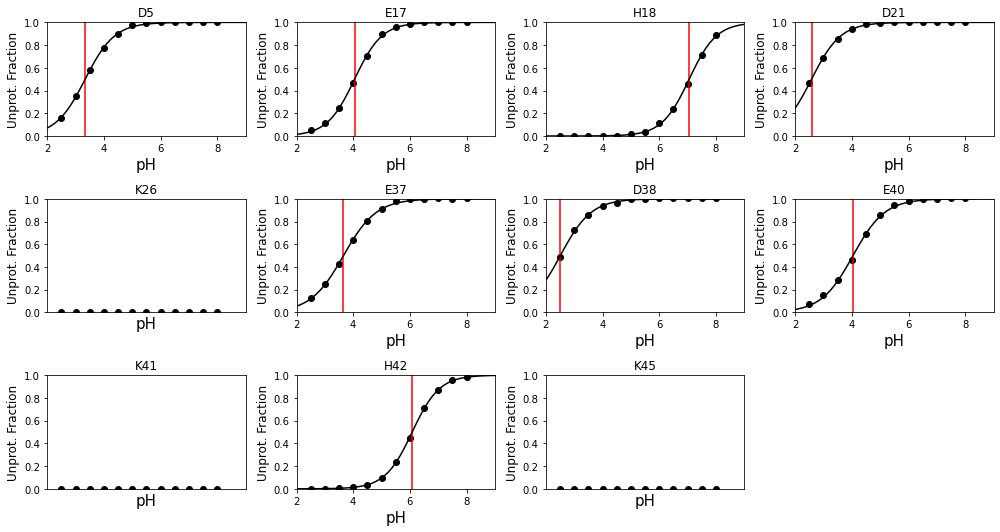

In [15]:
titles = ['D5', 'E17', 'H18', 'D21', 'K26', 'E37', 'D38', 'E40', 'K41', 'H42', 'K45']
plotting.plot_titration_curves(ph_objects, phs, resids, titles, xrange=[2,9])

# Analyse and Plot the Log Files

Create list of all your log files over the stages of simulation, start the list with the lowest stage of interest and then continue to the highest.

In [16]:
files = []
for stage in stages:
    files.append('amber_example_data/sample_{}/reps.log'.format(stage))

Process the log files

In [17]:
log_data = cphmd.log_analysis_amber(files)

The 'exchange_frq' command prints the exchange frequencies between pH replicas replicas.

In [18]:
for dat in log_data.exchange_frq:
    print("Exchange Frequency Between Replicas {0:>2.0f} - {1:>2.0f}: {2:0.2f}".format(dat[0], dat[1], dat[2]))

Exchange Frequency Between Replicas  0 -  1: 0.50
Exchange Frequency Between Replicas  1 -  2: 0.47
Exchange Frequency Between Replicas  2 -  3: 0.47
Exchange Frequency Between Replicas  3 -  4: 0.50
Exchange Frequency Between Replicas  4 -  5: 0.55
Exchange Frequency Between Replicas  5 -  6: 0.64
Exchange Frequency Between Replicas  6 -  7: 0.66
Exchange Frequency Between Replicas  7 -  8: 0.63
Exchange Frequency Between Replicas  8 -  9: 0.65
Exchange Frequency Between Replicas  9 - 10: 0.69
Exchange Frequency Between Replicas 10 - 11: 0.75


Finally plot the replica walks

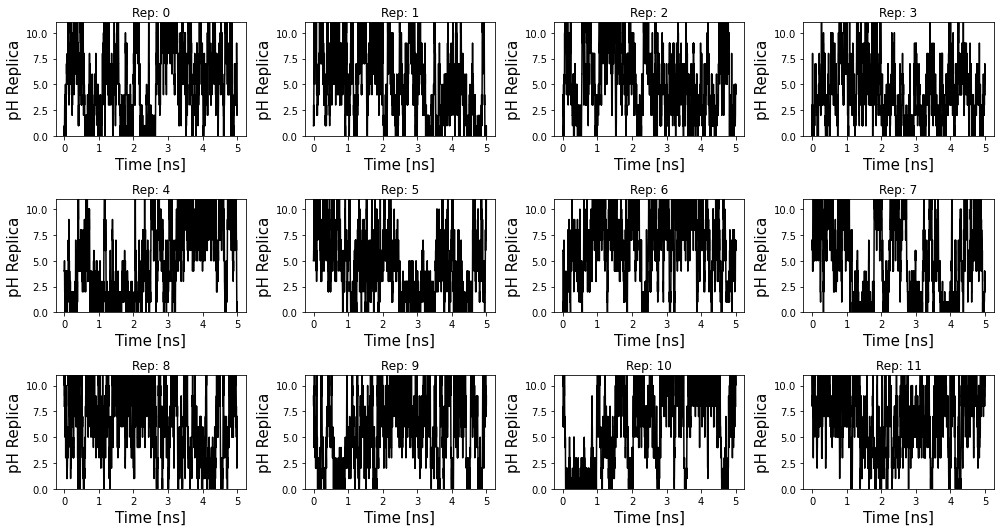

In [19]:
log_data.plot_replica_walk(xlabel='Time [ns]',  steps_to_time_conversion=(1/1000))